#Imports y Configuración Global  
En esta sección se importan todas las librerías necesarias para el análisis y modelado:  
- **pandas** y **numpy** para manipulación y cálculo numérico.  
- **matplotlib** para generación de gráficos estáticos.  
- **sklearn.preprocessing.MinMaxScaler** para escalar la serie al rango [0,1], requisito habitual en redes neuronales.  
- **sklearn.metrics.mean_absolute_error** para cuantificar la precisión del modelo en unidades reales (ppm).  
- **tensorflow.keras** (capas recurrentes, callbacks y modelo funcional) para definir y entrenar las redes RNN, LSTM y variantes.  
- **statsmodels** para métodos clásicos de series temporales (SARIMAX, pruebas de estacionariedad, ACF/PACF, descomposición STL).  

Asimismo, se instancian dos callbacks globales:  
- **EarlyStopping**: detiene el entrenamiento cuando la pérdida de validación deja de mejorar, evitando sobreajuste.  
- **TensorBoard**: registra métricas y histogramas de pesos para su visualización interactiva.  

Finalmente, se ajusta el estilo de las gráficas para asegurar coherencia visual en todo el notebook.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    SimpleRNN, LSTM, GRU, Bidirectional, Dense, Dropout,
    Attention, Input, Flatten
)
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Para tuner de hiperparámetros
!pip install keras-tuner --quiet
import keras_tuner as kt
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam

# Callbacks Globales
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tensorboard_cb = TensorBoard(log_dir='logs', histogram_freq=1)

# Estilo de gráficas
plt.rcParams.update({'axes.facecolor':'white','grid.color':'lightgray'})



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


<ipython-input-2-5d202928e3c3>:25: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


#  Funciones Genéricas  
Para evitar duplicar lógica en cada experimento se definen dos funciones reutilizables:  
1. **create_sequences(arr, window_size, horizon)**  
   - Convierte la serie univariante escalada en pares de entrada (`X`) y objetivo (`y`) mediante ventanas deslizantes de longitud `window_size`.  
   - Soporta predicción de un único paso (`horizon=1`) o múltiples pasos simultáneos.  
2. **train_and_eval(builder_fn, name, X_tr, y_tr, X_val, y_val, …)**  
   - Construye y compila el modelo llamando a `builder_fn()`.  
   - Entrena con `X_tr`/`y_tr` y valida con `X_val`/`y_val`, usando EarlyStopping y TensorBoard.  
   - Invierte la escala de las predicciones para comparar en ppm reales.  
   - Calcula y muestra el **MAE** (error absoluto medio).  
   - Grafica la curva de pérdida (train/val) y la comparación Real vs Predicción.  

Con estas funciones, cualquier nueva arquitectura o ajuste de datos puede evaluarse de forma homogénea.

In [ ]:
# 1. Crear secuencias (univariante o multistep)
def create_sequences(arr, window_size=12, horizon=1):
    X, y = [], []
    for i in range(len(arr) - window_size - (horizon-1)):
        X.append(arr[i:i+window_size,0])
        if horizon == 1:
            y.append(arr[i+window_size,0])
        else:
            y.append(arr[i+window_size:i+window_size+horizon,0])
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y)
    return X, y

# 2. Entrenamiento y evaluación
def train_and_eval(builder_fn, name, X_tr, y_tr, X_val, y_val,
                   epochs=30, batch_size=16):
    model = builder_fn()
    hist = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=epochs, batch_size=batch_size,
        callbacks=[es, tensorboard_cb],
        verbose=1
    )
    # Invertir escala y calcular MAE
    y_pred = model.predict(X_val)
    y_true_inv = scaler.inverse_transform(y_val.reshape(-1,1)).flatten()
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()
    mae = mean_absolute_error(y_true_inv, y_pred_inv)
    print(f"{name} MAE: {mae:.2f} ppm")
    # Gráficas opcionales
    plt.figure(figsize=(6,3))
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='val')
    plt.title(f'Loss {name}'); plt.legend(); plt.show()
    plt.figure(figsize=(6,3))
    plt.plot(y_true_inv, '.', label='Real')
    plt.plot(y_pred_inv, '.', label='Pred')
    plt.title(f'Real vs Pred {name}'); plt.legend(); plt.show()
    return model, hist, mae


#  Carga y Preprocesamiento  
Se prepara la serie de CO₂ para el modelado:  
1. **Carga del dataset** desde `statsmodels.datasets.co2`. La serie original es diaria y contiene valores faltantes.  
2. **Remuestreo a frecuencia mensual** usando la media de cada mes para obtener una serie más estable y sin NaNs.  
3. **Escalado** con `MinMaxScaler` al rango [0,1], que facilita la convergencia de las redes neuronales.  
4. **Creación de secuencias** de entrada y salida con `window_size=12` (un año de historia para predecir el siguiente mes).  
5. **Separación** en conjuntos de entrenamiento (80 %) y prueba (20 %), garantizando que la validación respete el orden temporal.


In [ ]:
# Carga y remuestreo
data = sm.datasets.co2.load_pandas().data
data.index = pd.to_datetime(data.index)
co2 = data['co2'].resample('M').mean().dropna()

# Escalado
scaler = MinMaxScaler()
scaled = scaler.fit_transform(co2.values.reshape(-1,1))

# Crear secuencias unistep
window_size = 12
X, y = create_sequences(scaled, window_size)

# Split 80/20
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]



<ipython-input-4-d9cd8bdae0ae>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  co2 = data['co2'].resample('M').mean().dropna()


#Construcción de Modelos y Generador de Hypermodels  

En esta sección se describen en detalle las arquitecturas empleadas para modelar la serie temporal y el mecanismo para ajustar sus hiperparámetros de forma automática:

---

## Builders fijos

Cada “builder” devuelve un modelo ya compilado, listo para entrenar, con una configuración estándar.  

- **RNN simple (SimpleRNN)**  
  Una red recurrente básica en la que cada neurona recibe como entrada no solo el vector en el tiempo actual, sino también su propio estado interno del paso anterior.  
  - *Ventaja:* Muy sencilla de implementar, útil para secuencias cortas.  
  - *Limitación:* Sufre del problema del “desvanecimiento del gradiente” en secuencias largas, lo que dificulta aprender dependencias a largo plazo.

- **LSTM (Long Short-Term Memory)**  
  Una variante de RNN que incorpora puertas (input, forget, output) para controlar el flujo de información y conservar gradientes útiles durante más pasos de tiempo.  
  - *Ventaja:* Captura dependencias de largo alcance en la serie (por ejemplo, ciclos estacionales).  
  - *Uso típico:* Pronósticos donde la memoria a largo plazo es crítica.

- **GRU (Gated Recurrent Unit)**  
  Similar a LSTM pero con una estructura más simple (dos puertas en lugar de tres).  
  - *Ventaja:* Menos parámetros que LSTM, entrena más rápido y a veces obtiene resultados comparables.  
  - *Caso de uso:* Cuando se busca un equilibrio entre capacidad de memoria y eficiencia de cómputo.

- **Bidirectional LSTM**  
  Dos capas LSTM en paralelo, una procesa la secuencia hacia adelante y la otra hacia atrás, y luego se combinan sus salidas.  
  - *Ventaja:* Puede aprovechar información tanto del pasado como del “futuro” relativo dentro de la ventana de entrada.  
  - *Aplicación:* Tareas donde el contexto de ambos lados de la ventana mejora la predicción (aunque complica ligeramente el entrenamiento).

- **LSTM con regularización (Dropout + L2)**  
  A la capa LSTM estándar se le añade:  
  1. **Dropout** en la salida de la capa recurrente (descarta aleatoriamente un porcentaje de neuronas en cada paso).  
  2. **Penalización L2** (weight decay) en los pesos de la capa recurrente y de la capa densa de salida.  
  - *Objetivo:* Reducir el sobreajuste, forzando al modelo a generalizar mejor a datos no vistos.

- **LSTM + Atención (Attention)**  
  Combina una capa LSTM (que devuelve la secuencia completa de estados) con un mecanismo de **Atención** que aprende a asignar un peso distinto a cada paso de la ventana:  
  1. La LSTM produce una matriz de estados `[timesteps × features]`.  
  2. La capa Attention calcula coeficientes que indican qué pasos temporales son más relevantes para la predicción.  
  3. Se genera un vector ponderado que resume la información más importante.  
  - *Beneficio:* Mejora la interpretabilidad (se puede visualizar qué rezagos “mira” el modelo) y, a menudo, la precisión.

---

## Generador de Hypermodels para KerasTuner

Para optimizar automáticamente la **cantidad de unidades** de la capa recurrente y la **tasa de aprendizaje**, se define una función `build_hypermodel(model_type)` que produce un “hypermodel”:

1. Recibe un parámetro `model_type` que indica la arquitectura a tunear (p.ej. “LSTM” o “GRU”).  
2. Dentro del hypermodel se crean dos espacios de búsqueda:  
   - **hp.Int(‘units’, 16, 128, step=16)** para probar distintas dimensiones de la capa oculta.  
   - **hp.Choice(‘lr’, [1e-2, 1e-3, 1e-4])** para seleccionar la tasa de aprendizaje óptima.  
3. Se compila el modelo con `Adam(lr)` y `loss='mse'`.  

KerasTuner explora este espacio mediante `RandomSearch` y devuelve los hiperparámetros que minimizan la **val_loss**, permitiendo re-entrenar las arquitecturas RNN, LSTM, GRU y Bi-LSTM con la configuración óptima sin intervención manual.



In [ ]:
# Builders fijos
def build_rnn():
    m = Sequential([ SimpleRNN(50, input_shape=(window_size,1)), Dense(1) ])
    m.compile('adam','mse')
    return m

def build_lstm():
    m = Sequential([ LSTM(50, input_shape=(window_size,1)), Dense(1) ])
    m.compile('adam','mse')
    return m

def build_gru():
    m = Sequential([ GRU(50, input_shape=(window_size,1)), Dense(1) ])
    m.compile('adam','mse')
    return m

def build_bilstm():
    m = Sequential([ Bidirectional(LSTM(50), input_shape=(window_size,1)), Dense(1) ])
    m.compile('adam','mse')
    return m

def build_lstm_reg():
    from tensorflow.keras import regularizers
    m = Sequential()
    m.add(LSTM(50,
               kernel_regularizer=regularizers.l2(1e-4),
               recurrent_regularizer=regularizers.l2(1e-4),
               input_shape=(window_size,1)))
    m.add(Dropout(0.2))
    m.add(Dense(1, kernel_regularizer=regularizers.l2(1e-4)))
    m.compile('adam','mse')
    return m

def build_lstm_attention():
    inp = Input(shape=(window_size,1))
    seq = LSTM(50, return_sequences=True)(inp)
    att = Attention()([seq, seq])
    flat = Flatten()(att)
    out = Dense(1)(flat)
    model = Model(inp, out)
    model.compile('adam','mse')
    return model

# Hypermodel builder para tuner
def build_hypermodel(model_type):
    def hypermodel(hp):
        units = hp.Int('units', 16, 128, step=16)
        lr    = hp.Choice('lr', [1e-2, 1e-3, 1e-4])
        m = Sequential()
        if model_type == 'RNN':
            m.add(SimpleRNN(units, input_shape=(window_size,1)))
        elif model_type == 'LSTM':
            m.add(LSTM(units, input_shape=(window_size,1)))
        elif model_type == 'GRU':
            m.add(GRU(units, input_shape=(window_size,1)))
        else:
            m.add(Bidirectional(LSTM(units), input_shape=(window_size,1)))
        m.add(Dense(1))
        m.compile(optimizer=Adam(lr), loss='mse')
        return m
    return hypermodel



#Entrenamiento, Búsqueda de Hiperparámetros y Comparativa  
Este bloque concentra todo el flujo de experimentación:  
1. **Entrenamiento de modelos base**  
   - Cada builder fijo entrena su modelo y devuelve el MAE.  
2. **Búsqueda de hiperparámetros**  
   - Con **RandomSearch** de KerasTuner se exploran múltiples combinaciones de `units` y `lr` durante varios “trials”.  
   - Se guardan los mejores valores para cada arquitectura.  
3. **Reentrenamiento afinado**  
   - Cada modelo principal (RNN, LSTM, GRU, Bi-LSTM) se reconstruye usando sus hiperparámetros óptimos y se re-entrena para obtener su MAE final.  
4. **Comparativa global**  
   - Se crea una tabla con los MAE de todos los modelos (base y afinados, así como modelos avanzados con regularización y atención).  
   - Se genera un gráfico de barras que permite identificar de un vistazo qué arquitectura y configuración ofrece el menor error.




>>> Entrenando RNN
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0208 - val_loss: 0.0300
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - val_loss: 0.0139
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020 - val_loss: 0.0103
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 0.0130
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.1651e-04 - val_loss: 0.0036
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014 - val_loss: 0.0044
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0288e-04 - val_loss: 0.0071
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8322e-04 - val_loss: 0.0086
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.3662e-04 - val_loss: 0.0063
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7589e-04 - val_loss: 0.0052
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
RNN MAE: 3.05 ppm


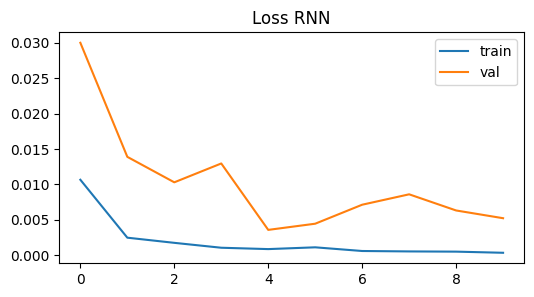

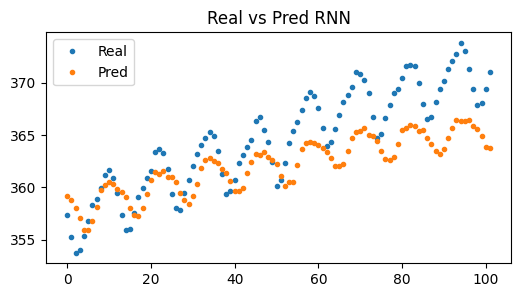


>>> Entrenando LSTM
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0975 - val_loss: 0.0019
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0053 - val_loss: 0.0024
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0016 - val_loss: 0.0049
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017 - val_loss: 0.0025
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
LSTM MAE: 2.26 ppm


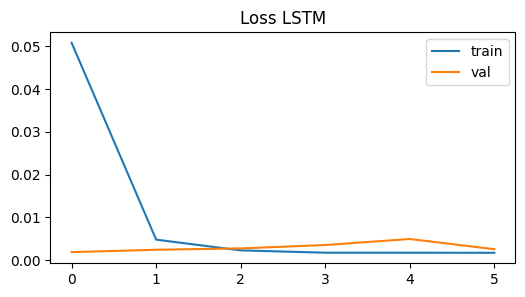

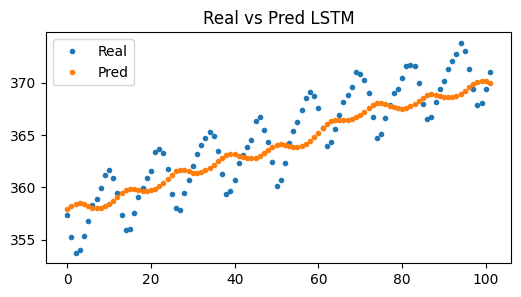


>>> Entrenando GRU
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0647 - val_loss: 0.0129
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0064 - val_loss: 0.0028
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 11/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 12/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012 - val_l

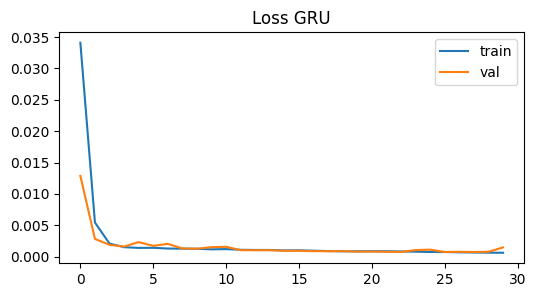

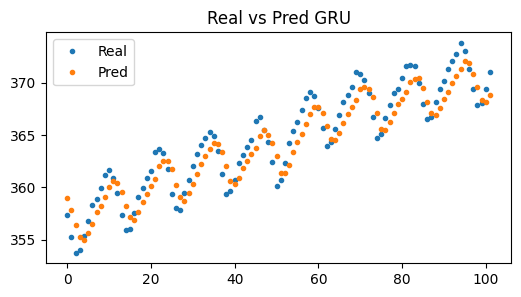


>>> Entrenando Bi-LSTM
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0428 - val_loss: 0.0215
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 11/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 12/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_l

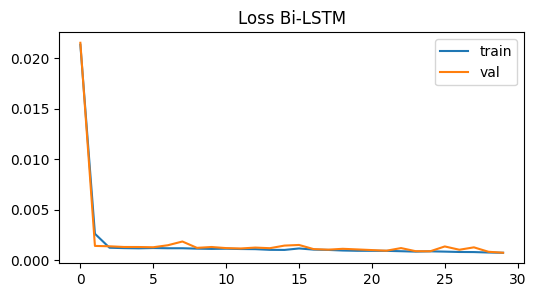

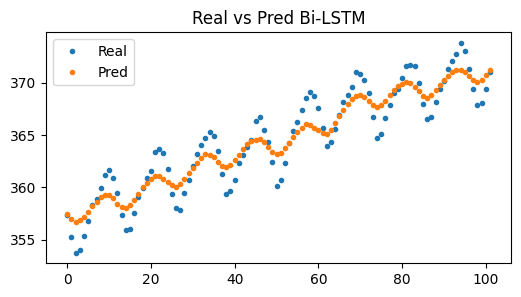


>>> Entrenando LSTM Reg
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.1110 - val_loss: 0.0078
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0134 - val_loss: 0.0095
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0098 - val_loss: 0.0101
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0074 - val_loss: 0.0054
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0068 - val_loss: 0.0054
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0064 - val_loss: 0.0047
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0061 - val_loss: 0.0044
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0062 - val_loss: 0.0042
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0054 - val_loss: 0.0042
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0055 - val_loss: 0.0049
Epoch 11/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 12/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0049 - val_l

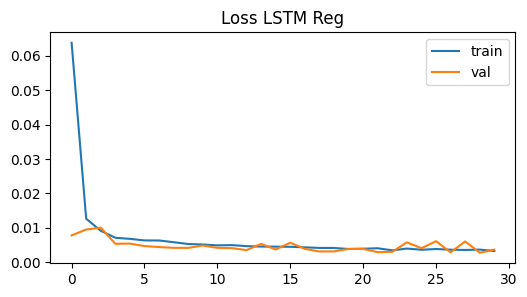

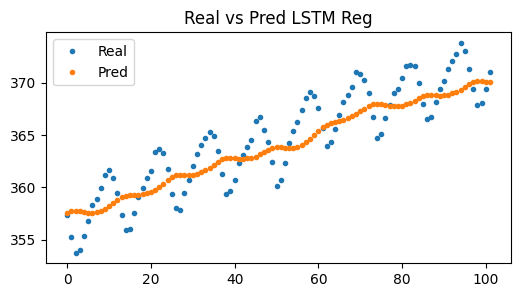


>>> Entrenando LSTM+Attn
Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0344 - val_loss: 0.0176
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 11/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 12/30
26/26 ━━━━━━━━━━━━━━━━━━━

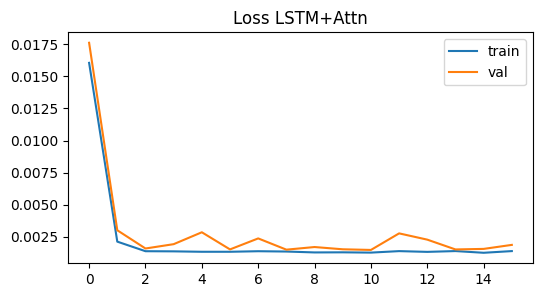

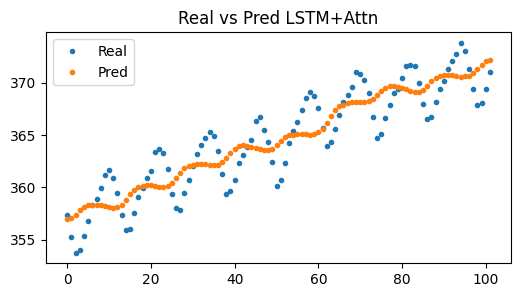


>>> Tuningeando RNN
Reloading Tuner from tuner_logs/RNN_tuning/tuner0.json
Mejores para RNN: {'units': 48, 'lr': 0.01}

>>> Tuningeando LSTM
Reloading Tuner from tuner_logs/LSTM_tuning/tuner0.json
Mejores para LSTM: {'units': 112, 'lr': 0.01}

>>> Tuningeando GRU
Reloading Tuner from tuner_logs/GRU_tuning/tuner0.json
Mejores para GRU: {'units': 96, 'lr': 0.01}

>>> Tuningeando Bi-LSTM
Reloading Tuner from tuner_logs/Bi-LSTM_tuning/tuner0.json
Mejores para Bi-LSTM: {'units': 48, 'lr': 0.01}

>>> Re-entrenando RNN tunedo (units=48, lr=0.01)
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1182 - val_loss: 0.0112
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.5444e-04 - val_loss: 0.0062
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4054e-04 - val_loss: 0.0044
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9555e-04 - val_loss: 0.0041
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7442e-04 - val_loss: 0.0031
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7415e-04 - val_loss: 0.0024
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6175e-04 - val_loss: 0.0021
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.3283e-04 - val_loss: 0.0031
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6707e-04 - val_loss: 9.9843e-04
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2982e-04 - val_loss: 5.8494e-04
Epoch 11/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5050e-04 - val_loss: 8.8766e-04
Epoch 12/30
26/26 ━━━━━━━━━━━

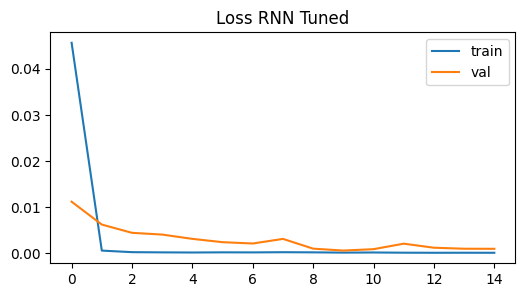

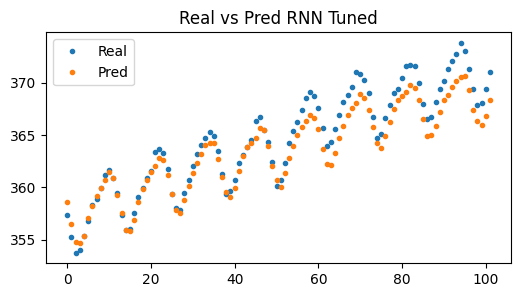


>>> Re-entrenando LSTM tunedo (units=112, lr=0.01)
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0617 - val_loss: 0.0362
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0045 - val_loss: 0.0015
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0012 - val_loss: 0.0067
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0010 - val_loss: 0.0021
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
LSTM Tuned MAE: 1.84 ppm


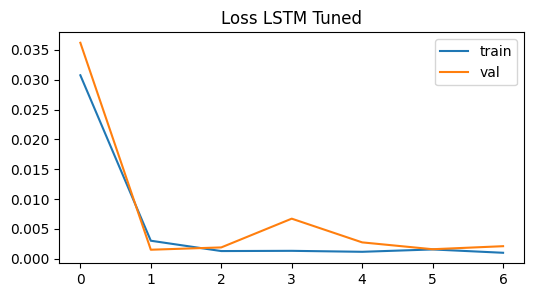

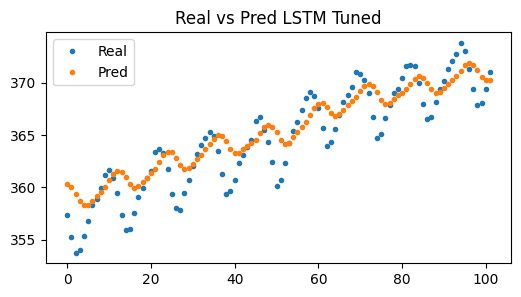


>>> Re-entrenando GRU tunedo (units=96, lr=0.01)
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0348 - val_loss: 9.6468e-04
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.8020e-04 - val_loss: 5.4193e-04
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.1127e-04 - val_loss: 5.2969e-04
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.5580e-04 - val_loss: 4.6035e-04
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.9646e-04 - val_loss: 3.9812e-04
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.8131e-04 - val_loss: 6.3741e-04
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.1714e-04 - val_loss: 4.6316e-04
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.3442e-04 - val_loss: 8.7225e-04
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.9453e-04 - val_loss: 4.4803e-04
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.4072e-04 - val_loss: 3.3968e-04
Epoch 11/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.7580e-04 - val_loss: 4

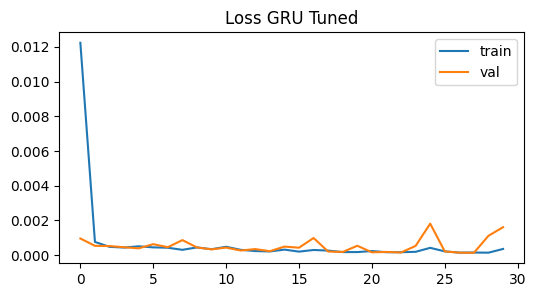

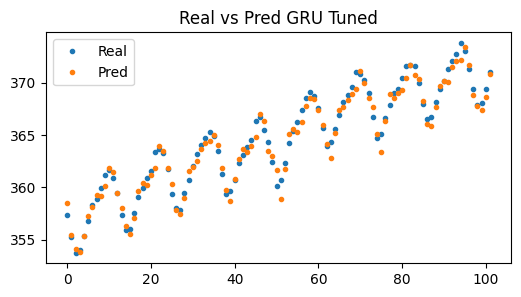


>>> Re-entrenando Bi-LSTM tunedo (units=48, lr=0.01)
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0366 - val_loss: 0.0045
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0020 - val_loss: 7.9846e-04
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.4490e-04 - val_loss: 6.6439e-04
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.9432e-04 - val_loss: 5.6298e-04
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.2220e-04 - val_loss: 4.8792e-04
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.8607e-04 - val_loss: 5.0911e-04
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.9767e-04 - val_loss: 2.0464e-04
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.1164e-04 - val_loss: 1.7147e-04
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.0500e-04 - val_loss: 2.1136e-04
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6137e-04 - val_loss: 1.5924e-04
Epoch 11/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.5932e-04 - val_loss: 5.1566e-0

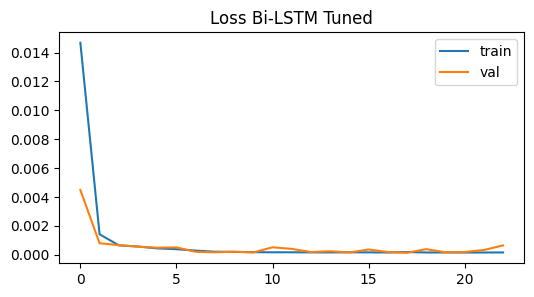

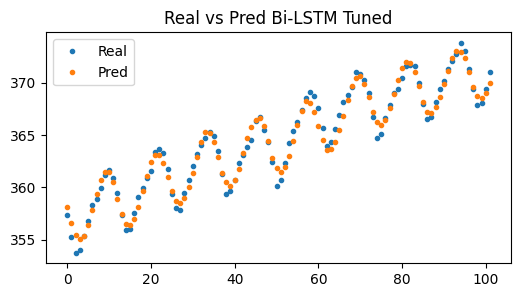

,Modelo,MAE (ppm)
0,RNN,3.054022
1,LSTM,2.264967
2,GRU,1.502617
3,Bi-LSTM,1.374867
4,LSTM Reg,2.121112
5,LSTM+Attn,2.004104
6,RNN Tuned,1.194419
7,LSTM Tuned,1.841096
8,GRU Tuned,0.587004
9,Bi-LSTM Tuned,0.581078


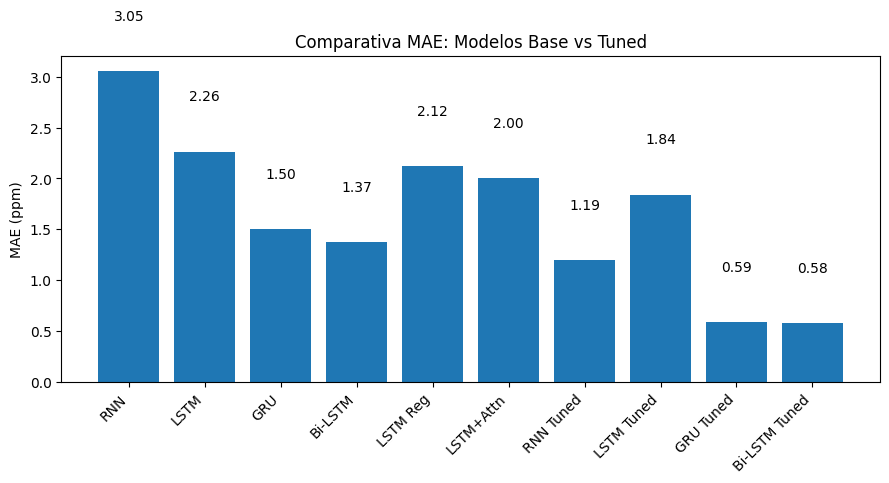

In [ ]:
# 4.1 Entrenar modelos base
model_builders = {
    'RNN': build_rnn,
    'LSTM': build_lstm,
    'GRU': build_gru,
    'Bi-LSTM': build_bilstm,
    'LSTM Reg': build_lstm_reg,
    'LSTM+Attn': build_lstm_attention
}

results = []
for name, builder in model_builders.items():
    print(f"\n>>> Entrenando {name}")
    _, _, mae = train_and_eval(builder, name, X_train, y_train, X_test, y_test)
    results.append((name, mae))

# 4.2 Tuning automático (5 trials cada uno)
best_hps = {}
for arch in ['RNN','LSTM','GRU','Bi-LSTM']:
    print(f"\n>>> Tuningeando {arch}")

    tuner = kt.RandomSearch(
    build_hypermodel(arch),
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_logs',
    project_name=f'{arch}_tuning'
)
    tuner.search(X_train, y_train,
                 validation_data=(X_test, y_test),
                 epochs=10,
                 callbacks=[es],
                 verbose=1)
    best = tuner.get_best_hyperparameters(1)[0].values
    best_hps[arch] = best
    print(f"Mejores para {arch}: {best}")

# 4.3 Re-entrenar modelos tuned
for arch, hps in best_hps.items():
    units, lr = hps['units'], hps['lr']
    print(f"\n>>> Re-entrenando {arch} tunedo (units={units}, lr={lr})")
    # Creamos builder dinámico
    def builder_tuned(arch=arch, units=units, lr=lr):
        m = Sequential()
        if arch == 'RNN':
            m.add(SimpleRNN(units, input_shape=(window_size,1)))
        elif arch == 'LSTM':
            m.add(LSTM(units, input_shape=(window_size,1)))
        elif arch == 'GRU':
            m.add(GRU(units, input_shape=(window_size,1)))
        else:
            m.add(Bidirectional(LSTM(units), input_shape=(window_size,1)))
        m.add(Dense(1))
        m.compile(optimizer=Adam(lr), loss='mse')
        return m

    _, _, mae = train_and_eval(builder_tuned, f"{arch} Tuned",
                               X_train, y_train, X_test, y_test)
    results.append((f"{arch} Tuned", mae))

# 4.4 Tabla y gráfico comparativo final
comp_df = pd.DataFrame(results, columns=['Modelo','MAE (ppm)'])
display(comp_df)

plt.figure(figsize=(9,5))
plt.bar(comp_df['Modelo'], comp_df['MAE (ppm)'])
plt.title('Comparativa MAE: Modelos Base vs Tuned')
plt.ylabel('MAE (ppm)')
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(comp_df['MAE (ppm)']):
    plt.text(i, v + 0.5, f"{v:.2f}", ha='center')
plt.tight_layout()
plt.show()
